<a href="https://colab.research.google.com/github/axelpuyo/liasd/blob/master/perceptive_bias_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installs requirements and mounts file to Google Drive in order to save models.

In [ ]:
## Run once
!pip -q install import-ipynb

from google.colab import drive
drive.mount('/content/drive')

# check path
import os
print(os.getcwd())
print(os.listdir())

# cd your_path
%cd drive/MyDrive/Colab Notebooks/liasd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/liasd
['perceptive_bias_model.ipynb', 'saved_models', 'utils.ipynb', 'explainers.ipynb', 'post_analysis.ipynb', 'colored_mnist.ipynb']
[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/liasd'
/content/drive/MyDrive/Colab Notebooks/liasd


Necessary imports, please note that when any imported .ipynb files are modified, you need to restart runtime (CTRL + M or Runtime > Restart Runtime) in order for changes to take effect.

In [ ]:
## Imports
import import_ipynb
import utils
import colored_mnist
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

SHAP's `DeepExplainer` does not support TensorFlow 2.0+ (namely eager-mode by default), while `Grad-CAM` requires it. Thus, we train the same model on two different versions of TensorFlow (1.x and 2.x behavior). However, the behavior of TensorFlow can only be changed at the beginning of a runtime. **In order to switch versions, you need to restart runtime**. 



In [ ]:
# ## TensorFlow version swapping (SHAP works with TF 1.x, GRAD-CAM with TF 2.x) 
tf1 = True
if tf1:
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

print('TensorFlow 2.x behavior ? ', tf.executing_eagerly())

TensorFlow 2.x behavior ?  False


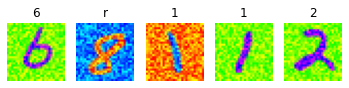

In [ ]:
num = 8000
(digit, background, noise) = (True, True, True)
(train_images, train_colors, train_numbers, train_mixed), (test_images, test_colors, test_numbers, test_mixed) = colored_mnist.load_data(num, digit, background, noise, verbose=True)

In [ ]:
## Models
# Color-biased model
color_model = keras.Sequential()
color_model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=train_images[0].shape, name='conv1'))
color_model.add(keras.layers.MaxPool2D(pool_size=(2,2), name='pool1'))
color_model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', name='conv2'))
color_model.add(keras.layers.MaxPool2D(pool_size=(2,2), padding='same', name='pool2'))
color_model.add(keras.layers.Flatten())
color_model.add(keras.layers.Dense(13))
color_model.add(keras.layers.Softmax())

input_shape = train_images.shape
color_model.build(input_shape)

color_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# color_model.summary()

print('>> Color-biased model training')
color_model.fit(train_images, train_colors, batch_size=12, epochs=5, shuffle=True)

>> Color-biased model training
Train on 8000 samples
Epoch 1/5
8000/8000 [==============================] - 2s 263us/sample - loss: 0.0129 - acc: 0.9954
Epoch 2/5
8000/8000 [==============================] - 2s 248us/sample - loss: 1.1924e-07 - acc: 1.0000
Epoch 3/5
8000/8000 [==============================] - 2s 247us/sample - loss: 1.1922e-07 - acc: 1.0000
Epoch 4/5
8000/8000 [==============================] - 2s 239us/sample - loss: 1.1921e-07 - acc: 1.0000
Epoch 5/5
8000/8000 [==============================] - 2s 277us/sample - loss: 1.1921e-07 - acc: 1.0000


In [ ]:
# Shape-biased model
shape_model = keras.Sequential()
shape_model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=train_images[0].shape, name='conv1'))
shape_model.add(keras.layers.MaxPool2D(pool_size=(2,2), name='pool1'))
shape_model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', name='conv2'))
shape_model.add(keras.layers.MaxPool2D(pool_size=(2,2), padding='same', name='pool2'))
shape_model.add(keras.layers.Flatten())
shape_model.add(keras.layers.Dense(13))
shape_model.add(keras.layers.Softmax())

input_shape = train_images.shape
shape_model.build(input_shape)

shape_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# shape_model.summary()

print('>> Shape-biased model training')
shape_model.fit(train_images, train_numbers, batch_size=12, epochs=15, shuffle=True)

>> Shape-biased model training
Train on 8000 samples
Epoch 1/15
8000/8000 [==============================] - 3s 434us/sample - loss: 0.8027 - acc: 0.7400
Epoch 2/15
8000/8000 [==============================] - 2s 308us/sample - loss: 0.1693 - acc: 0.9510
Epoch 3/15
8000/8000 [==============================] - 2s 237us/sample - loss: 0.1132 - acc: 0.9669
Epoch 4/15
8000/8000 [==============================] - 2s 238us/sample - loss: 0.0852 - acc: 0.9747
Epoch 5/15
8000/8000 [==============================] - 2s 249us/sample - loss: 0.0657 - acc: 0.9816
Epoch 6/15
8000/8000 [==============================] - 2s 237us/sample - loss: 0.0538 - acc: 0.9841
Epoch 7/15
8000/8000 [==============================] - 2s 237us/sample - loss: 0.0394 - acc: 0.9886
Epoch 8/15
8000/8000 [==============================] - 2s 241us/sample - loss: 0.0306 - acc: 0.9919
Epoch 9/15
8000/8000 [==============================] - 2s 271us/sample - loss: 0.0270 - acc: 0.9925
Epoch 10/15
8000/8000 [===============

In [ ]:
# Rule-biased model
model = keras.Sequential()
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=train_images[0].shape, name='conv1'))
model.add(keras.layers.MaxPool2D(pool_size=(2,2), name='pool1'))
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', name='conv2'))
model.add(keras.layers.MaxPool2D(pool_size=(2,2), padding='same', name='pool2'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(13))
model.add(keras.layers.Softmax())

input_shape = train_images.shape
model.build(input_shape)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

print('>> Rule-biased model training')
model.fit(train_images, train_mixed, batch_size=12, epochs=25, shuffle=True)

>> Rule-biased model training
Train on 8000 samples
Epoch 1/25
8000/8000 [==============================] - 2s 251us/sample - loss: 0.5287 - acc: 0.8313
Epoch 2/25
8000/8000 [==============================] - 2s 234us/sample - loss: 0.1276 - acc: 0.9609
Epoch 3/25
8000/8000 [==============================] - 2s 238us/sample - loss: 0.0834 - acc: 0.9764
Epoch 4/25
8000/8000 [==============================] - 2s 239us/sample - loss: 0.0639 - acc: 0.9821
Epoch 5/25
8000/8000 [==============================] - 2s 239us/sample - loss: 0.0468 - acc: 0.9862
Epoch 6/25
8000/8000 [==============================] - 2s 237us/sample - loss: 0.0349 - acc: 0.9906
Epoch 7/25
8000/8000 [==============================] - 2s 236us/sample - loss: 0.0265 - acc: 0.9919
Epoch 8/25
8000/8000 [==============================] - 2s 237us/sample - loss: 0.0214 - acc: 0.9944
Epoch 9/25
8000/8000 [==============================] - 2s 236us/sample - loss: 0.0165 - acc: 0.9955
Epoch 10/25
8000/8000 [================

Saves models in tf1 or tf2 directories depending on the TensorFlow version that was used.

In [ ]:
## Save models   
color_path = utils.pathfinder(tf1, digit, background, noise, 'color')
shape_path = utils.pathfinder(tf1, digit, background, noise, 'shape')
rule_path = utils.pathfinder(tf1, digit, background, noise, 'rule')

color_model.save(color_path, overwrite=True)
shape_model.save(shape_path, overwrite=True)
model.save(rule_path, overwrite=True)

In [ ]:
print(color_path)

/content/drive/MyDrive/Colab Notebooks/liasd/saved_models/tf1/digit/background/noise/color_biased
